In [43]:
from pathlib import Path
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
# from pyspark.conf import SparkConf
from pyspark.sql.functions import col, sum, count, when, lit, udf
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType, ArrayType

from skrebate import ReliefF

In [3]:
# Initialize Spark Session
spark: SparkSession = SparkSession.builder\
    .appName("pyspark-notebook")\
    .master("spark://127.0.0.1:7077")\
    .config("spark.driver.host", "host.docker.internal") \
    .config("spark.driver.bindAddress", "0.0.0.0")\
    .config("spark.executor.memory", "2g")\
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "2")\
    .config("spark.hadoop.fs.s3a.block.size", "33554432") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "admin") \
    .config("spark.hadoop.fs.s3a.secret.key", "password") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.attempts.maximum", "0") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

Spark Version: 3.5.1


In [4]:
volume_path = "s3a://mybucket/cicids2017" 

local_path = "./CICIDS2017"
all_files = glob.glob(local_path + "/*.csv")

volume_files = [volume_path + file.removeprefix(local_path) for file in all_files]
print("\n".join(volume_files))

s3a://mybucket/cicids2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
s3a://mybucket/cicids2017\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
s3a://mybucket/cicids2017\Friday-WorkingHours-Morning.pcap_ISCX.csv
s3a://mybucket/cicids2017\Monday-WorkingHours.pcap_ISCX.csv
s3a://mybucket/cicids2017\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
s3a://mybucket/cicids2017\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
s3a://mybucket/cicids2017\Tuesday-WorkingHours.pcap_ISCX.csv
s3a://mybucket/cicids2017\Wednesday-workingHours.pcap_ISCX.csv


In [5]:
df = spark.read \
    .option("nullValue", "NA") \
    .option("emptyValue", "unknown") \
    .csv(volume_files, header=True, inferSchema=True) \
    .repartition(12) \
    .cache()

In [6]:
df.show(10)

+-----------------+--------------+------------------+-----------------------+---------------------------+----------------------------+----------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+------------+---------------+--------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+------------+------------+------------+-------------+--------------+--------------+--------------+--------------------+------------------+-------------+--------------+------------------+------------------+-------------------+------------------+-----------------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------------+---------------------+---------------------+--------------------+----

In [7]:
df.columns

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 'Flow Bytes/s',
 ' Flow Packets/s',
 ' Flow IAT Mean',
 ' Flow IAT Std',
 ' Flow IAT Max',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Max',
 ' Fwd IAT Min',
 'Bwd IAT Total',
 ' Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Bwd IAT Min',
 'Fwd PSH Flags',
 ' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Bwd URG Flags',
 ' Fwd Header Length34',
 ' Bwd Header Length',
 'Fwd Packets/s',
 ' Bwd Packets/s',
 ' Min Packet Length',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 'FIN Flag Count',
 ' SYN Flag Count',
 ' RST Flag Count',
 '

Count the number of null values in each column

In [8]:
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

null_counts.show()

+-----------------+--------------+------------------+-----------------------+---------------------------+----------------------------+----------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+------------+---------------+--------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+------------+------------+------------+-------------+--------------+--------------+--------------+--------------------+------------------+-------------+--------------+------------------+------------------+-------------------+------------------+-----------------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------------+---------------------+---------------------+--------------------+----

In [9]:
# Rename the ' Label' column to 'Label'
df = df.withColumnRenamed(' Label', 'Label')

Check if there are any null values in the DataFrame

In [10]:
has_nulls = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().sum().sum() > 0
print("Any nulls in DataFrame:", has_nulls)

Any nulls in DataFrame: False


Remove duplicated columns

In [11]:
unique_columns = list(dict.fromkeys(df.columns))
df = df.select(unique_columns)

Get more details

In [12]:
print("Data types of columns:")
df.printSchema()

Data types of columns:
root
 |--  Destination Port: integer (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |--  Flow Packets/s: double (nullable = true)
 |--  Flow IAT Mean: double (nullable = true)
 |--  Flow IAT Std: double (nullable = true)
 |--  Flow IAT Max: integer 

In [13]:
# Describe numerical columns and show basic statistics
df.describe().show()

+-------+-----------------+--------------------+------------------+-----------------------+---------------------------+----------------------------+----------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+------------+---------------+------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+------------------+-------------------+-----------------+-------------------+--------------+--------------------+--------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+-----------------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------

In [14]:
# Group by 'Label' and count occurrences
label_counts = df.groupBy('Label').count().orderBy('count', ascending=False)
label_counts.show()

+--------------------+-------+
|               Label|  count|
+--------------------+-------+
|              BENIGN|2273097|
|            DoS Hulk| 231073|
|            PortScan| 158930|
|                DDoS| 128027|
|       DoS GoldenEye|  10293|
|         FTP-Patator|   7938|
|         SSH-Patator|   5897|
|       DoS slowloris|   5796|
|    DoS Slowhttptest|   5499|
|                 Bot|   1966|
|Web Attack � Brut...|   1507|
|    Web Attack � XSS|    652|
|        Infiltration|     36|
|Web Attack � Sql ...|     21|
|          Heartbleed|     11|
+--------------------+-------+



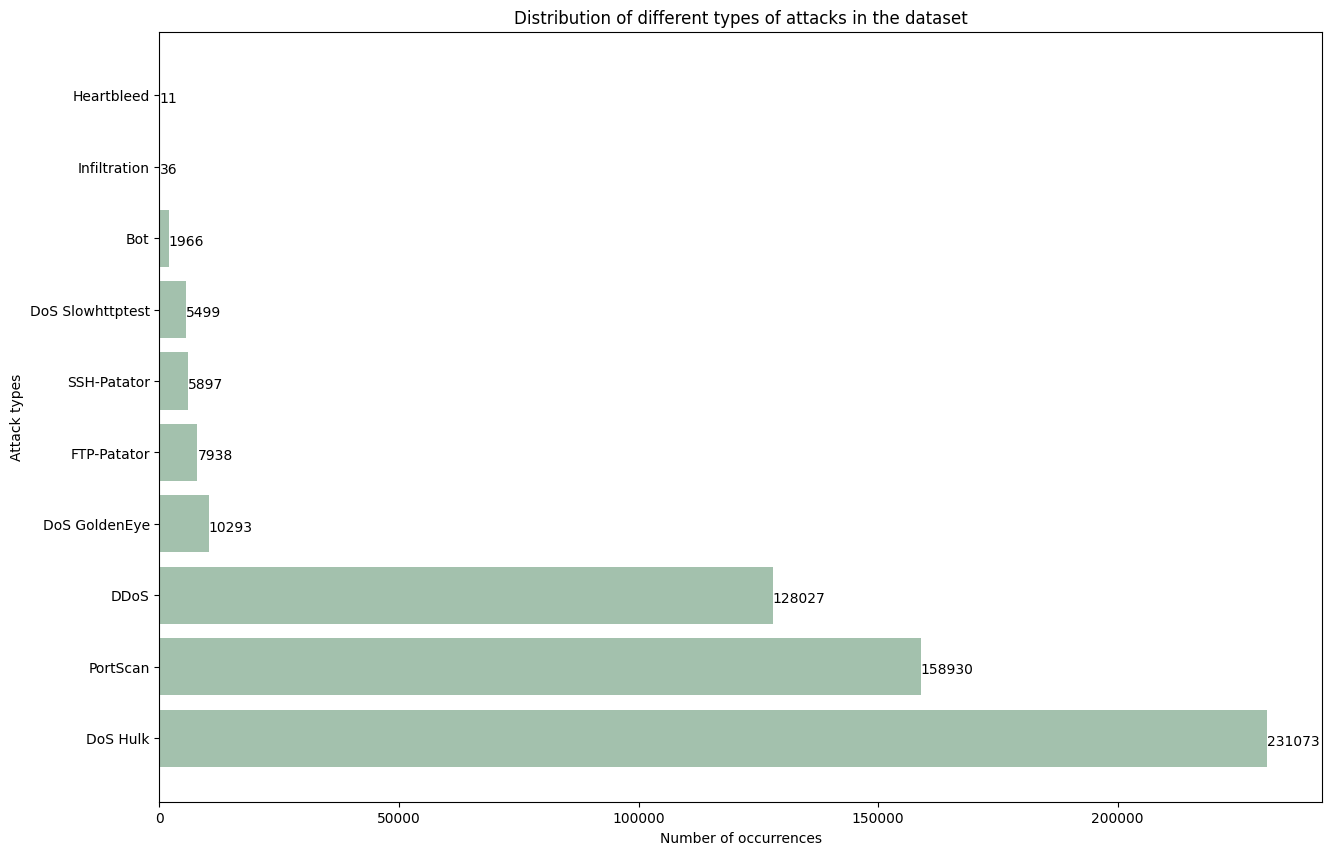

In [17]:
attack = ('DoS Hulk', 'PortScan', 'DDoS', 'DoS GoldenEye', 'FTP-Patator', 'SSH-Patator', 'DoS Slowloris',
          'DoS Slowhttptest', 'Bot', 'Web Attack: Brute Force', 'Web Attack: XSS', 'Infiltration', 
          'Web Attack: SQL Injection', 'Heartbleed')
label_counts_pd = label_counts.toPandas()

# Sort and filter to match the attack list (ignoring index 0 if it's not in attack list)
label_counts_pd = label_counts_pd[label_counts_pd['Label'].isin(attack)].sort_values('count', ascending=False)
amount = label_counts_pd['count'].values
attacks_in_data = label_counts_pd['Label'].values

plt.figure(figsize=(15, 10))
y_pos = np.arange(len(attacks_in_data))  # Adjust based on actual data
plt.barh(y_pos, amount, align='center', color='#a3c1ad')
plt.yticks(y_pos, attacks_in_data)  # Use actual labels from data
plt.title('Distribution of different types of attacks in the dataset')
plt.xlabel('Number of occurrences')
plt.ylabel('Attack types')
for i, v in enumerate(amount):
    plt.text(v + 3, i - 0.1, str(v))
plt.show()

There are only 11, 21, 36 instances of Heartbleed, Web Attack � Sql Injection, Infiltration. So, we will drop it since it will not be sufficient trianing data.

In [18]:
df = df.replace(['Heartbleed', 'Web Attack � Sql Injection', 'Infiltration'], None, subset=['Label'])
df = df.dropna(how='any')

In [19]:
# Count occurrences of each value in 'Label' column
label_counts = df.groupBy('Label').count().orderBy('count', ascending=False)
label_counts.show()

+--------------------+-------+
|               Label|  count|
+--------------------+-------+
|              BENIGN|2272688|
|            DoS Hulk| 230124|
|            PortScan| 158930|
|                DDoS| 128027|
|       DoS GoldenEye|  10293|
|         FTP-Patator|   7938|
|         SSH-Patator|   5897|
|       DoS slowloris|   5796|
|    DoS Slowhttptest|   5499|
|                 Bot|   1966|
|Web Attack � Brut...|   1507|
|    Web Attack � XSS|    652|
+--------------------+-------+



In [20]:
# Replace 'Web Attack � Brute Force' with 'Brute Force'
df = df.withColumn('Label', when(col('Label') == 'Web Attack � Brute Force', 'Brute Force').otherwise(col('Label')))

# Replace 'Web Attack � XSS' with 'XSS'
df = df.withColumn('Label', when(col('Label') == 'Web Attack � XSS', 'XSS').otherwise(col('Label')))

We will add a binary attack column - indicating a 0 if benign, or 1 if there was an attack.

And, group attack methods

In [21]:
df = df.withColumn('Attack', when(col('Label') == 'BENIGN', 0).otherwise(1))

In [22]:
# Define attack group mapping
attack_group = {
    'BENIGN': 'benign', 
    'DoS Hulk': 'dos',
    'PortScan': 'probe', 
    'DDoS': 'ddos',
    'DoS GoldenEye': 'dos', 
    'FTP-Patator': 'brute_force',
    'SSH-Patator': 'brute_force', 
    'DoS slowloris': 'dos', 
    'DoS Slowhttptest': 'dos',
    'Bot': 'botnet',
    'Brute Force': 'web_attack', 
    'XSS': 'web_attack'
}

# Create 'Label_Category' column by mapping 'Label' to attack_group
# Use when/otherwise to simulate mapping
conditions = [when(col('Label') == k, lit(v)) for k, v in attack_group.items()]
df = df.withColumn('Label_Category', conditions[0])  # Start with first condition
for condition in conditions[1:]:  # Chain the rest
    df = df.withColumn('Label_Category', when(col('Label_Category').isNull(), condition).otherwise(col('Label_Category')))

# Count occurrences of each value in 'Label_Category'
label_category_counts = df.groupBy('Label_Category').count().orderBy('count', ascending=False)
label_category_counts.show()

+--------------+-------+
|Label_Category|  count|
+--------------+-------+
|        benign|2272688|
|           dos| 251712|
|         probe| 158930|
|          ddos| 128027|
|   brute_force|  13835|
|    web_attack|   2159|
|        botnet|   1966|
+--------------+-------+



+------+-------+
|Attack|  count|
+------+-------+
|     0|2272688|
|     1| 556629|
+------+-------+



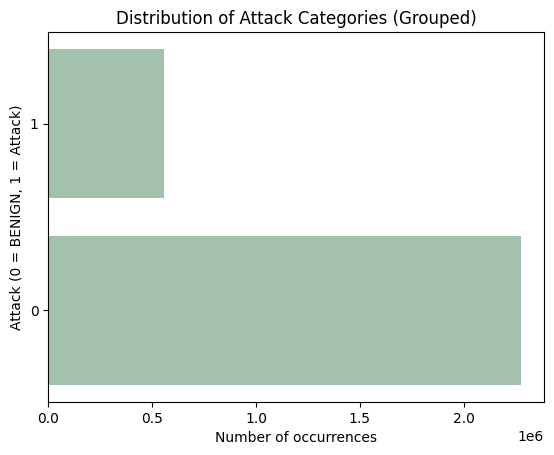

In [23]:
attack_counts = df.groupBy('Attack').count().orderBy('count', ascending=False)
attack_counts.show()

# Collect data to driver for plotting
attack_counts_pd = attack_counts.toPandas()
attack_labels = attack_counts_pd['Attack'].astype(str).values  # Convert to string for plotting
attack_values = attack_counts_pd['count'].values

# Plot distribution of 'Attack'
plt.figure()
plt.barh(attack_labels, attack_values, color='#a3c1ad')
plt.title('Distribution of Attack Categories (Grouped)')
plt.xlabel('Number of occurrences')
plt.ylabel('Attack (0 = BENIGN, 1 = Attack)')
plt.show()

+--------------+-------+
|Label_Category|  count|
+--------------+-------+
|        benign|2272688|
|           dos| 251712|
|         probe| 158930|
|          ddos| 128027|
|   brute_force|  13835|
|    web_attack|   2159|
|        botnet|   1966|
+--------------+-------+



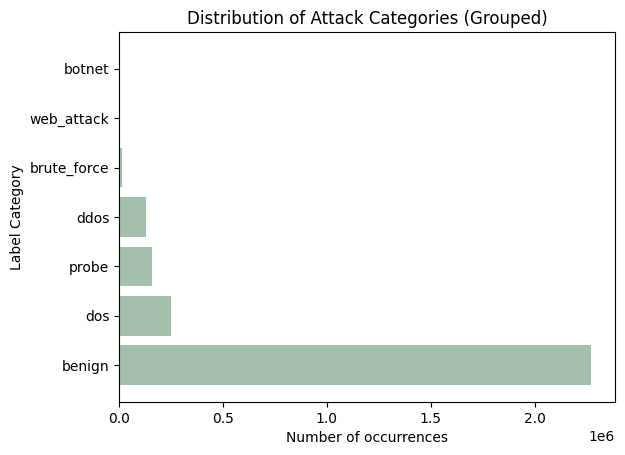

In [24]:
label_category_counts = df.groupBy('Label_Category').count().orderBy('count', ascending=False)
label_category_counts.show()

# Collect data to driver for plotting
label_category_counts_pd = label_category_counts.toPandas()
label_category_labels = label_category_counts_pd['Label_Category'].values
label_category_values = label_category_counts_pd['count'].values

# Plot distribution of 'Label_Category'
plt.figure()
plt.barh(label_category_labels, label_category_values, color='#a3c1ad')
plt.title('Distribution of Attack Categories (Grouped)')
plt.xlabel('Number of occurrences')
plt.ylabel('Label Category')
plt.show()

+----------------+-------+
|           Label|  count|
+----------------+-------+
|          BENIGN|2272688|
|        DoS Hulk| 230124|
|        PortScan| 158930|
|            DDoS| 128027|
|   DoS GoldenEye|  10293|
|     FTP-Patator|   7938|
|     SSH-Patator|   5897|
|   DoS slowloris|   5796|
|DoS Slowhttptest|   5499|
|             Bot|   1966|
|     Brute Force|   1507|
|             XSS|    652|
+----------------+-------+



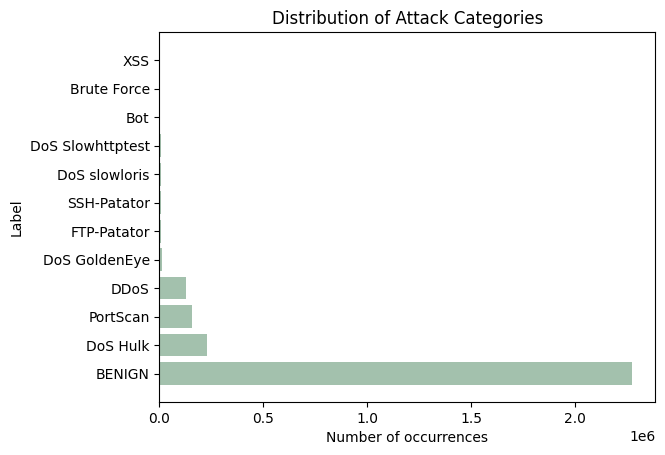

In [25]:
label_counts = df.groupBy('Label').count().orderBy('count', ascending=False)
label_counts.show()

# Collect data to driver for plotting
label_counts_pd = label_counts.toPandas()
label_labels = label_counts_pd['Label'].values
label_values = label_counts_pd['count'].values

# Plot distribution of 'Label'
plt.figure()
plt.barh(label_labels, label_values, color='#a3c1ad')
plt.title('Distribution of Attack Categories')
plt.xlabel('Number of occurrences')
plt.ylabel('Label')
plt.show()

## Split Data

Split data using 60:20:20 ratio, for training, test and validation dataset. We stratified so that the attack rate remained the same across all 3 sets.

In [26]:
# 3 Different labeling options
attacks = ['Label', 'Label_Category', 'Attack']

# 1. Separate features (xs) and labels (ys) into a combined DataFrame
xs_columns = [c for c in df.columns if c not in attacks]
df_combined = df.select(xs_columns + attacks)

# Desired split: 60% train, 20% test, 20% validate
weights = [0.6, 0.2, 0.2]
train_df, test_df, validate_df = df_combined.randomSplit(weights, seed=0)


Separate features and labels for each split

In [27]:
# Training set
x_train = train_df.select(xs_columns)
y_train = train_df.select(attacks)

# Test set
x_test = test_df.select(xs_columns)
y_test = test_df.select(attacks)

# Validation set
x_validate = validate_df.select(xs_columns)
y_validate = validate_df.select(attacks)

Verify the splits

In [28]:
print("Training set size:", x_train.count())
print("Test set size:", x_test.count())
print("Validation set size:", x_validate.count())

Training set size: 1695975
Test set size: 566992
Validation set size: 566350


In [29]:
print("Label distribution in train:")
y_train.groupBy('Label').count().show()

Label distribution in train:
+----------------+-------+
|           Label|  count|
+----------------+-------+
|          BENIGN|1362643|
|     SSH-Patator|   3577|
|   DoS slowloris|   3437|
|        DoS Hulk| 137981|
|             XSS|    372|
|        PortScan|  95070|
|DoS Slowhttptest|   3274|
|             Bot|   1163|
|   DoS GoldenEye|   6163|
|            DDoS|  76645|
|     FTP-Patator|   4750|
|     Brute Force|    900|
+----------------+-------+



In [30]:
print("Label distribution in test:")
y_test.groupBy('Label').count().show()

Label distribution in test:
+----------------+------+
|           Label| count|
+----------------+------+
|          BENIGN|455359|
|     SSH-Patator|  1152|
|   DoS slowloris|  1154|
|        DoS Hulk| 46180|
|             XSS|   127|
|        PortScan| 31918|
|DoS Slowhttptest|  1134|
|             Bot|   387|
|   DoS GoldenEye|  2063|
|            DDoS| 25644|
|     FTP-Patator|  1558|
|     Brute Force|   316|
+----------------+------+



In [31]:
print("Label distribution in validate:")
y_validate.groupBy('Label').count().show()

Label distribution in validate:
+----------------+------+
|           Label| count|
+----------------+------+
|          BENIGN|454686|
|     SSH-Patator|  1168|
|   DoS slowloris|  1205|
|        DoS Hulk| 45963|
|             XSS|   153|
|        PortScan| 31942|
|DoS Slowhttptest|  1091|
|             Bot|   416|
|   DoS GoldenEye|  2067|
|            DDoS| 25738|
|     FTP-Patator|  1630|
|     Brute Force|   291|
+----------------+------+



## Normalization

Convert to vector format

In [32]:
# Convert feature columns to a single vector column for scaling
def to_vector_df(df, feature_cols):
    to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())
    
    escaped_cols = [f"`{col}`" for col in feature_cols]
    return df.selectExpr("*", "array(" + ", ".join(escaped_cols) + ") as array_features") \
            .withColumn("features", to_vector_udf(col("array_features"))) \
            .select("features")

feature_cols = x_train.columns

In [38]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
x_train_vector = assembler.transform(x_train).select("features")
x_validate_vector = assembler.transform(x_validate).select("features")
x_test_vector = assembler.transform(x_test).select("features")

In [39]:
# Initialize and fit MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(x_train_vector)

Apply normalization to dataset

In [40]:
x_train_scaled = scaler_model.transform(x_train_vector).select("scaled_features")
x_validate_scaled = scaler_model.transform(x_validate_vector).select("scaled_features")
x_test_scaled = scaler_model.transform(x_test_vector).select("scaled_features")

Verify that all values are between 0 and 1

In [44]:
# Flatten the scaled features and compute statistics
to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Convert VectorUDT to array and explode
flattened_train = x_train_scaled.withColumn("scaled_array", to_array_udf(col("scaled_features"))) \
                               .selectExpr("explode(scaled_array) as value")
stats = flattened_train.describe("value")
stats.show()

+-------+-------------------+
|summary|              value|
+-------+-------------------+
|  count|          132286050|
|   mean|0.14760183095566667|
| stddev| 0.2882658152139109|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

